In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import numpy as np

In [2]:
file_paths = [
    '400 iterations/remind_SSP2-PkBudg1150-SPS1_2020_400it.xlsx',
    # 'stats/remind_SSP2-PkBudg1150-SPS1_2025.xlsx',
    '400 iterations/remind_SSP2-PkBudg1150-SPS1_2030_400it.xlsx',
    # 'stats/remind_SSP2-PkBudg1150-SPS1_2035.xlsx',
    '400 iterations/remind_SSP2-PkBudg1150-SPS1_2040_400it.xlsx',
    # 'stats/remind_SSP2-PkBudg1150-SPS1_2045.xlsx',
    '400 iterations/remind_SSP2-PkBudg1150-SPS1_2050_400it.xlsx'
]

# years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
years = [2020, 2030, 2040, 2050]

In [3]:
dfs = []
for file_path, year in zip(file_paths, years):
    df = pd.read_excel(file_path, sheet_name='Total impacts')
    df['year'] = year
    dfs.append(df)

data = pd.concat(dfs)

In [4]:
blue_color = '#1f77b4'

# Figure 1 - LCI

In [5]:
impact_categories = {
    'EF v3.1 EN15804 - climate change - global warming potential (GWP100)':'Global warming potential',
    'ReCiPe 2016 v1.03, midpoint (H) - particulate matter formation - particulate matter formation potential (PMFP)':'Particulate matter formation',
    'EF v3.1 EN15804 - acidification - accumulated exceedance (AE)': 'Acidification',
    'EF v3.1 EN15804 - ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)':'Ecotoxicity: freshwater',
    'Inventory results and indicators - resources - total surface occupation':'Land use',
    'Inventory results and indicators - resources - total freshwater extraction': 'Water use',
    'Crustal Scarcity Indicator 2020 - material resources: metals/minerals - crustal scarcity potential (CSP)':'Crustal scarcity indicator',
    'EF v3.1 EN15804 - material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)': 'Abiotic depletion potential',
}

In [6]:
impact_units = {
    'Global warming potential': r'Mton CO$_2$ eq.',
    'Particulate matter formation': r'kton PM$_{2.5}$ eq.',
    'Crustal scarcity indicator': r'Gton Si eq.',
    'Abiotic depletion potential': r'ton Sb eq.',
    'Acidification': r'M mol H$^+$ eq.',
    'Ecotoxicity: freshwater': r'B CTUe',
    'Land use': r'km$^2$ $\cdot$ year',
    'Water use': r'hm$^3$',    
}


In [7]:
scaling_factors = {
    'Global warming potential': 1e-9,  # kg to megatonnes
    'Particulate matter formation': 1e-6, # kg to kilotonnes
    'Crustal scarcity indicator':1e-12, # kg to gigatonnes
    'Abiotic depletion potential': 1e-3,  # kg to tonnes
    'Acidification': 1e-6,  # mol to M moles
    'Ecotoxicity: freshwater': 1e-9,  # CTUe to billion CTUe
    'Land use': 1e-6,  # m²a to square kilometers
    'Water use': 1e-6,  # m³ to kliters
}

In [8]:
y_limits = {
    'Global warming potential': (0, 50),
    'Particulate matter formation': (20,40),
    'Crustal scarcity indicator':(3,8),
    'Abiotic depletion potential': (150, 750),
    'Acidification': (75, 150),
    'Ecotoxicity: freshwater': (100, 200),
    'Land use': (3000, 8000),
    'Water use': (60, 120),
}

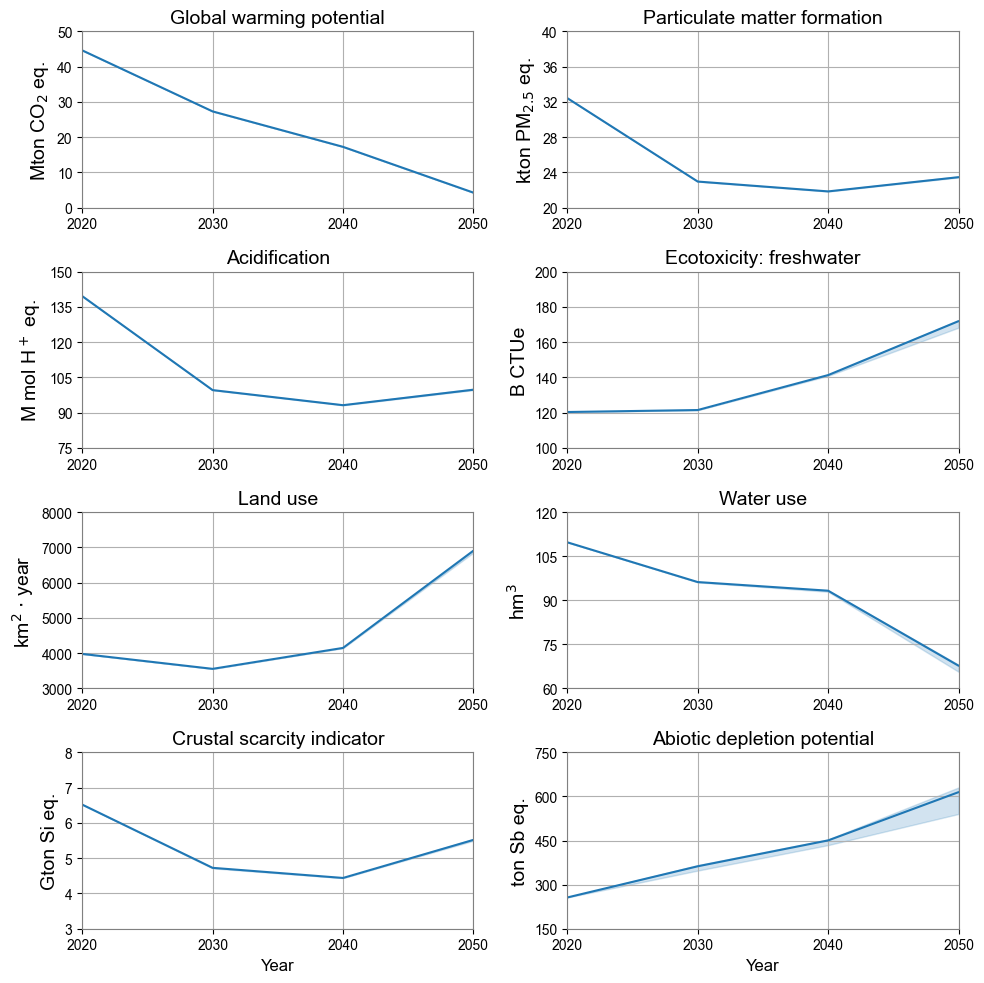

In [9]:
num_categories = len(impact_categories)
fig, axes = plt.subplots(nrows=(num_categories + 1) // 2, ncols=2, figsize=(10, 10))  # Adjust the figsize as needed
axes = axes.flatten()

for i, (ax, (category, display_name)) in enumerate(zip(axes, impact_categories.items())):
    sns.set(style="whitegrid")

    scale = scaling_factors[display_name]  # Get the scaling factor for the category

    for region in data['region'].unique():
        region_data = data[data['region'] == region]
        years_grouped = region_data.groupby('year')[category].apply(lambda x: x * scale)  # Apply the scaling factor
        q05 = years_grouped.groupby('year').quantile(0.05)
        q50 = years_grouped.groupby('year').quantile(0.5)
        q95 = years_grouped.groupby('year').quantile(0.95)
        
        sns.lineplot(x=q50.index, y=q50, ax=ax, color=blue_color)
        ax.fill_between(q50.index, q05, q95, alpha=0.2, color=blue_color)
    
    ax.set_title(display_name, fontsize=14)
    
    # Set y-label with units
    ax.set_ylabel(f'{impact_units[display_name]}', fontsize=14)
    
    # Manually set y-limits based on provided values
    ax.set_ylim(y_limits[display_name])
    
    # Set reasonable y-ticks
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    # Remove scientific notation
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    
    ax.set_xlim(2020, 2050)
    ax.set_xticks([2020, 2030, 2040, 2050])
    
    # Set x-label only for bottom plots
    if i >= len(axes) - 2:
        ax.set_xlabel('Year', fontsize=12)
    else:
        ax.set_xlabel('')

    ax.grid(True)
    
    # Remove legend if it exists
    legend = ax.get_legend()
    if legend is not None:
        ax.legend().remove()

    # Set external border color to grey
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')

# Hide any unused subplots
for ax in axes[len(impact_categories):]:
    ax.set_visible(False)

# Adjust vertical spacing between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.4)  # Adjust space between plots

plt.tight_layout()
plt.savefig('Figure_1_LCIA_400it_onlyshares.png', dpi=300)
plt.show()

In [10]:
# # Plot for each impact category using Seaborn
# fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20))
# axes = axes.flatten()

# for ax, (category, display_name) in zip(axes, impact_categories.items()):
#     sns.set(style="whitegrid")

#     for region in data['region'].unique():
#         region_data = data[data['region'] == region]
#         years_grouped = region_data.groupby('year')[category]
#         q05 = years_grouped.quantile(0.05)
#         q50 = years_grouped.quantile(0.5)
#         q95 = years_grouped.quantile(0.95)
        
#         sns.lineplot(x=years, y=q50, ax=ax)
#         ax.fill_between(years, q05, q95, alpha=0.2)
    
#     ax.set_title(display_name, fontsize=16)
#     ax.set_xlabel('Year', fontsize=14)
#     ax.set_ylabel('Impact', fontsize=14)
#     ax.set_ylim(0,None)
#     ax.set_xlim(2020, 2050)
#     ax.grid(True)

# plt.tight_layout()
# # plt.savefig('impact_categories_combined.png', dpi=300)
# plt.show()

# Figure 2 - Selected RELICS

In [11]:
relics_categories = [
    'RELICS - metals extraction - Lithium',
    'RELICS - metals extraction - Cobalt',
    'RELICS - metals extraction - Vanadium',
    'RELICS - metals extraction - Platinum',
    'RELICS - metals extraction - Palladium',
    'RELICS - metals extraction - Iridium',
    'RELICS - metals extraction - Neodymium',
    'RELICS - metals extraction - Gallium',
    'RELICS - metals extraction - Sulfur'
]

impact_categories = {col: col.split(' - ')[-1] for col in relics_categories}
impact_categories

{'RELICS - metals extraction - Lithium': 'Lithium',
 'RELICS - metals extraction - Cobalt': 'Cobalt',
 'RELICS - metals extraction - Vanadium': 'Vanadium',
 'RELICS - metals extraction - Platinum': 'Platinum',
 'RELICS - metals extraction - Palladium': 'Palladium',
 'RELICS - metals extraction - Iridium': 'Iridium',
 'RELICS - metals extraction - Neodymium': 'Neodymium',
 'RELICS - metals extraction - Gallium': 'Gallium',
 'RELICS - metals extraction - Sulfur': 'Sulfur'}

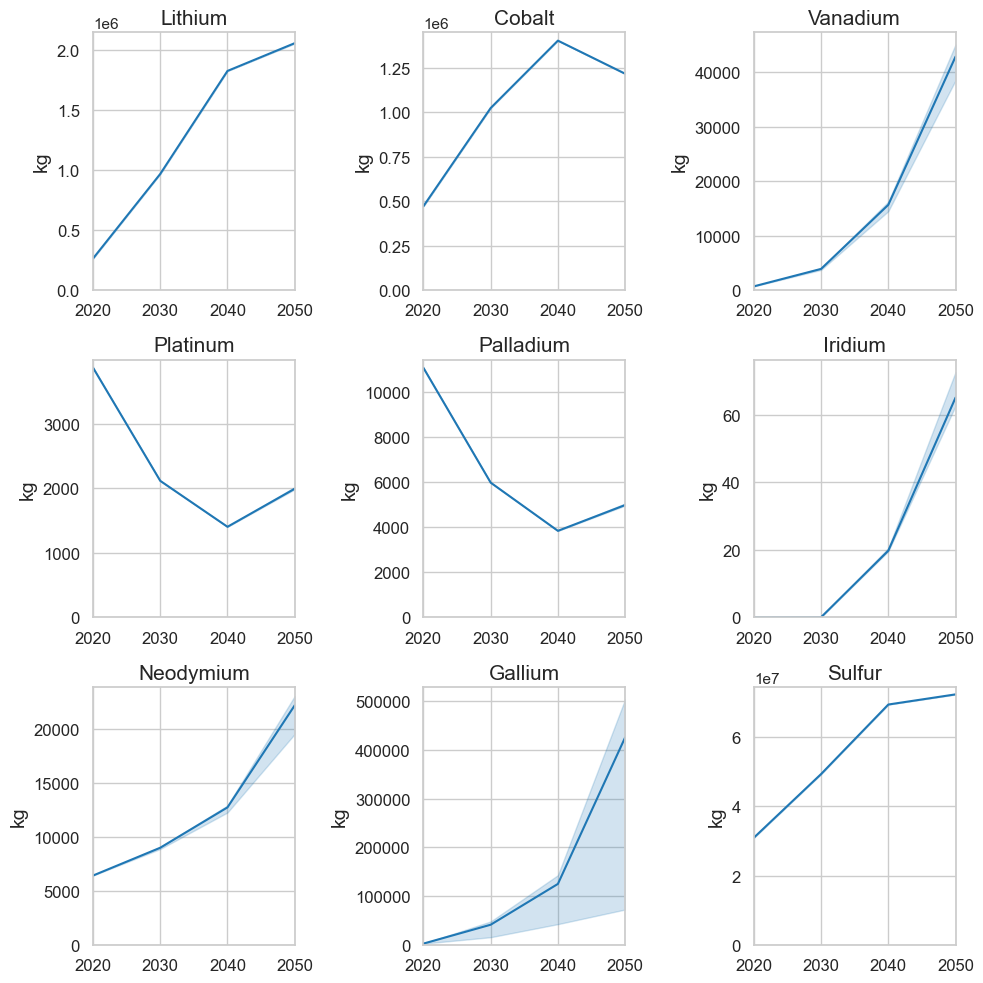

In [12]:
fig_width = 10  
fig_height = 10  
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(fig_width, fig_height))
axes = axes.flatten()

for ax, (category, display_name) in zip(axes, impact_categories.items()):
    sns.set(style="whitegrid")

    for region in data['region'].unique():
        region_data = data[data['region'] == region]
        years_grouped = region_data.groupby('year')[category]
        q05 = years_grouped.quantile(0.05)
        q50 = years_grouped.quantile(0.5)
        q95 = years_grouped.quantile(0.95)
        
        sns.lineplot(x=q50.index, y=q50, ax=ax, color = blue_color)
        ax.fill_between(q50.index, q05, q95, alpha=0.2, color = blue_color)
    
    ax.set_title(display_name, fontsize=15)
    ax.set_ylabel('kg', fontsize=14)
    ax.set_xlabel('', fontsize=12)
    ax.set_xlim(2020, 2050)
    ax.set_ylim(0, None)
    ax.set_xticks([2020, 2030, 2040, 2050])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)

for i in range(len(impact_categories), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('Figure_2_RELICS_400it_only_shares.png', dpi=350)
plt.show()

# Figure 3 - RELICS

In [5]:
impact_categories = {col: col.split(' - ')[-1] for col in data.columns if 'RELICS - metals extraction' in col and 'Germanium' not in col and 'Rubidium' not in col}

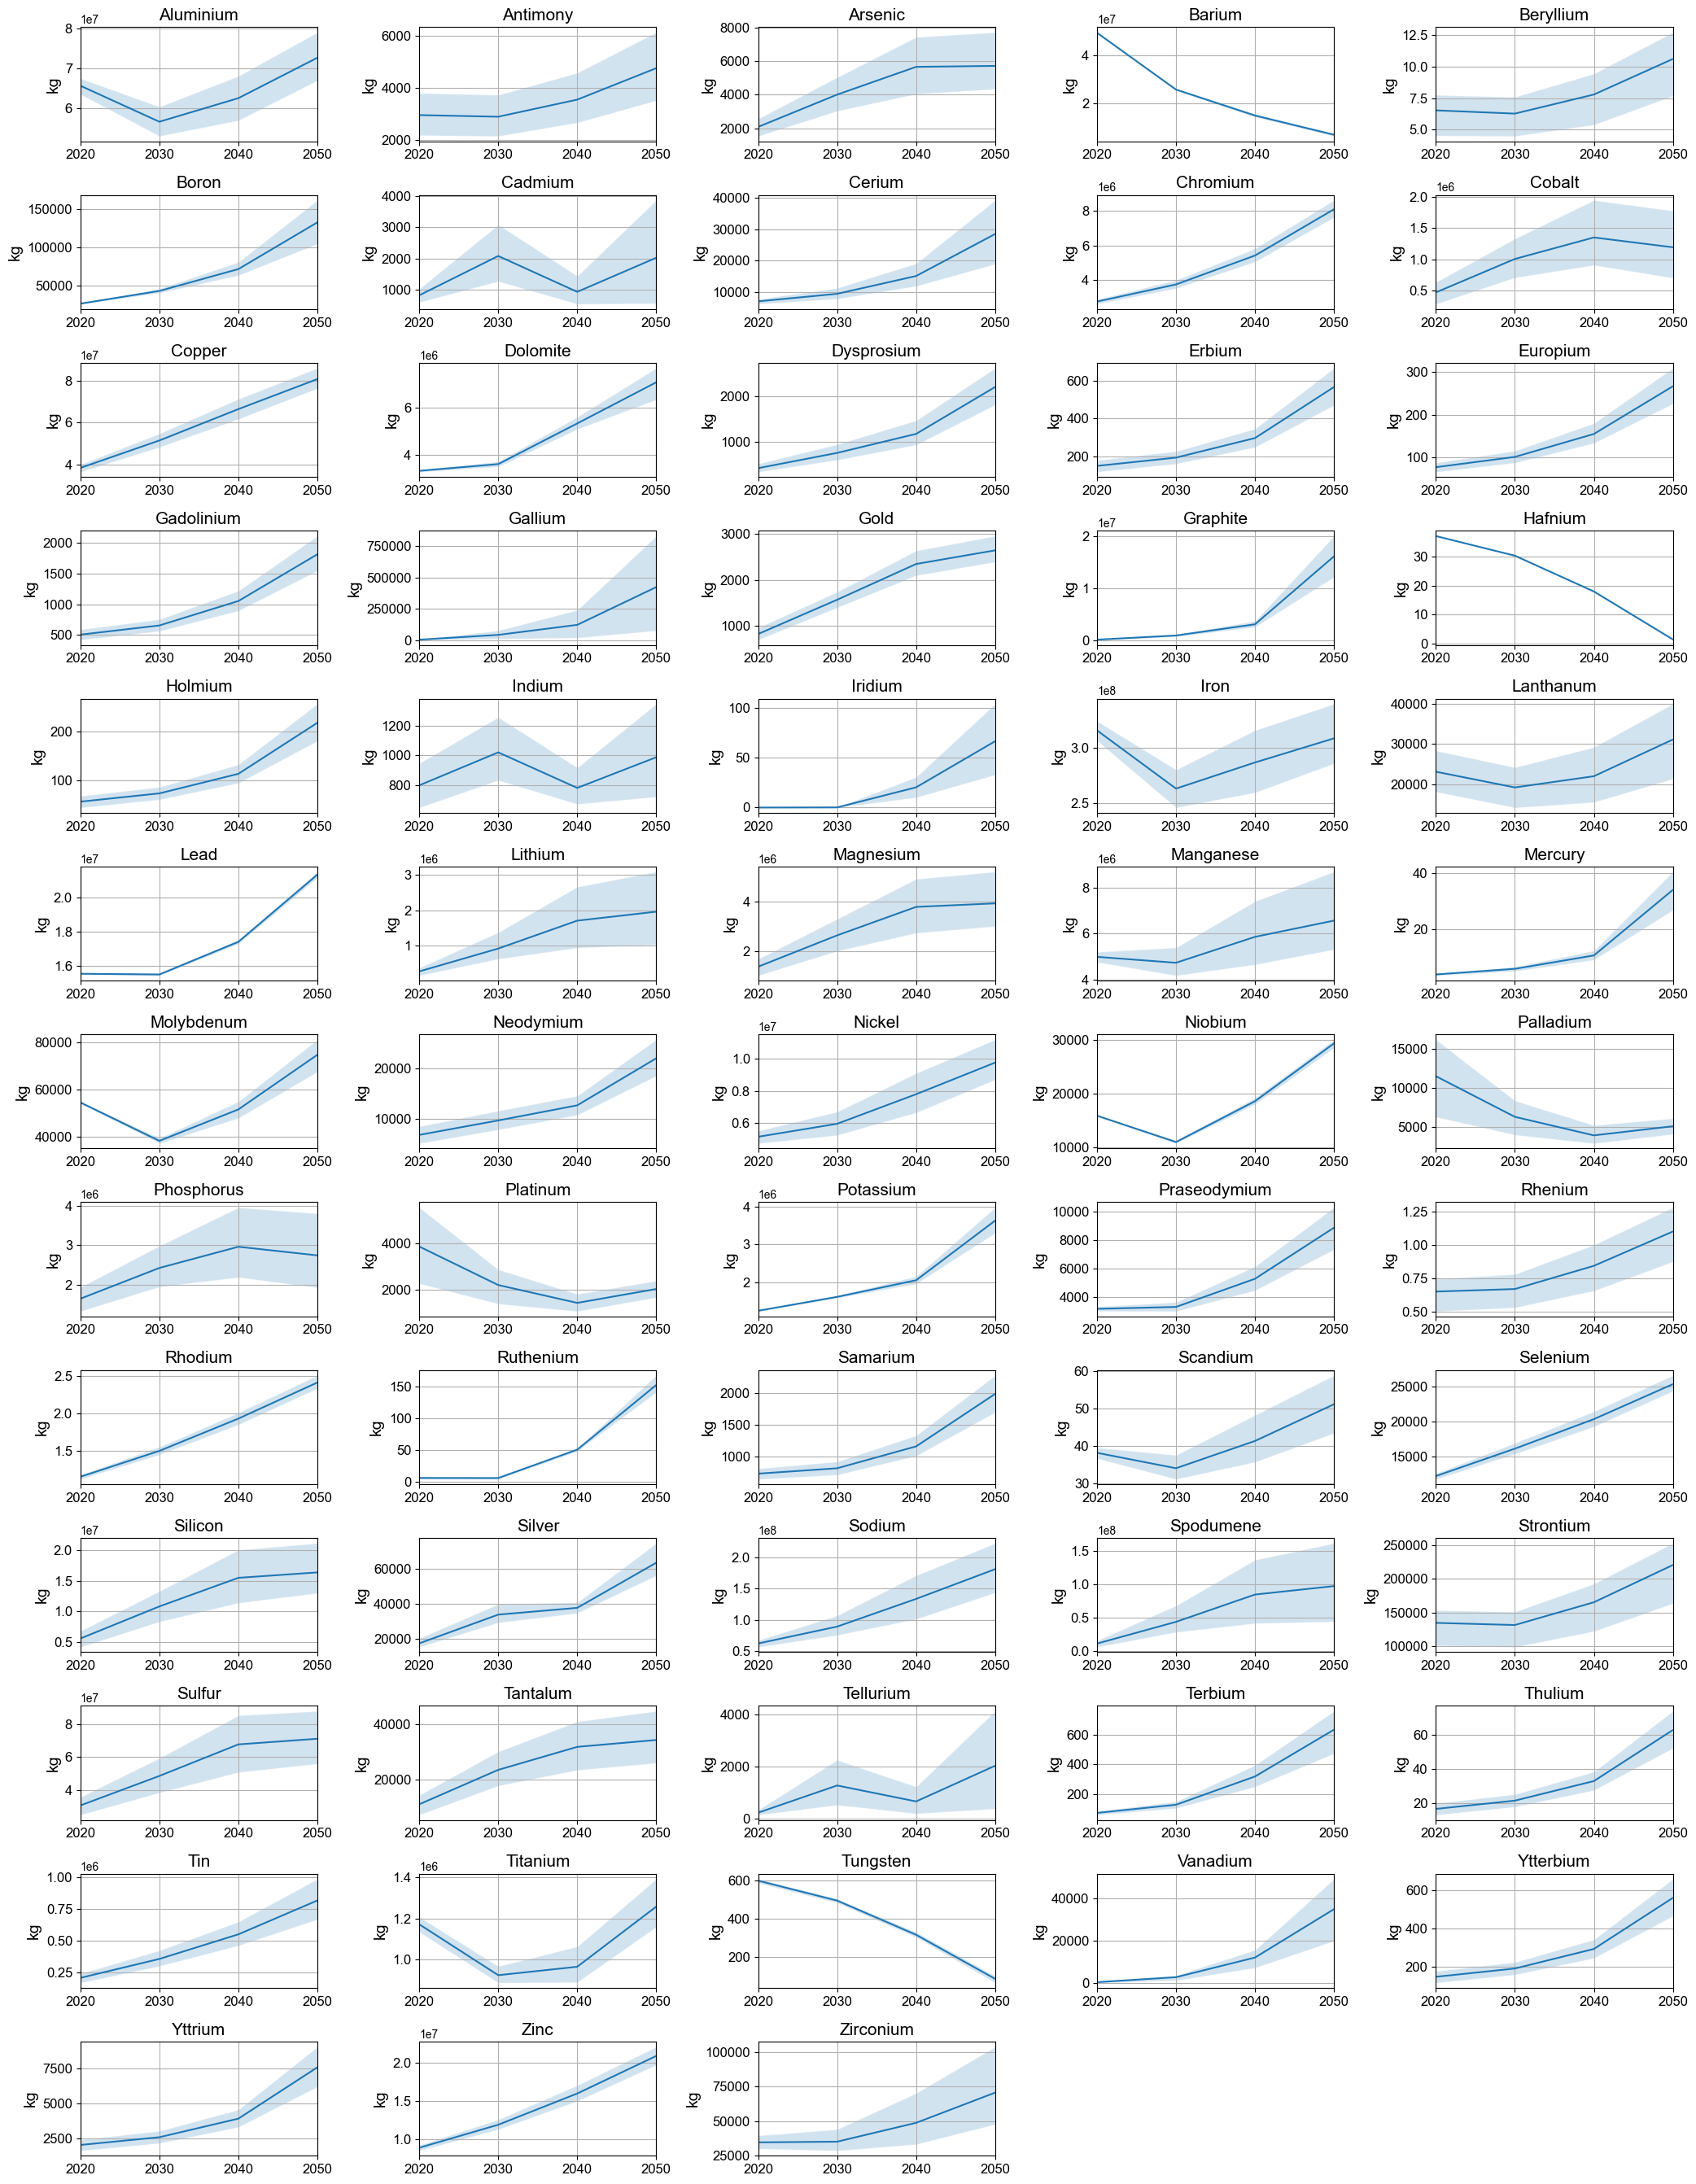

In [6]:
# Calculate the appropriate size for A4 paper
fig_width = 21  # A4 width in inches
fig_height = 27  # Calculate height based on 0.8 inches per row
fig, axes = plt.subplots(nrows=13, ncols=5, figsize=(fig_width, fig_height))
axes = axes.flatten()

for ax, (category, display_name) in zip(axes, impact_categories.items()):
    sns.set(style="whitegrid")

    for region in data['region'].unique():
        region_data = data[data['region'] == region]
        years_grouped = region_data.groupby('year')[category]
        q05 = years_grouped.quantile(0.05)
        q50 = years_grouped.quantile(0.5)
        q95 = years_grouped.quantile(0.95)
        
        sns.lineplot(x=q50.index, y=q50, ax=ax)
        ax.fill_between(q50.index, q05, q95, alpha=0.2)
    
    ax.set_title(display_name, fontsize=15)
    ax.set_ylabel('kg', fontsize=14)
    ax.set_xlabel('', fontsize=12)
    ax.set_xlim(2020, 2050)
    # ax.set_ylim(0, None)
    ax.set_xticks([2020, 2030, 2040, 2050])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)

# Hide any unused subplots
for i in range(len(impact_categories), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('Figure_3_RELICS_400it.png', dpi=350)
plt.show()

# READ RESULTS

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms

In [21]:
df_SPS1_Budg1150 = pd.read_parquet('results_SSP2-PkBudg1150-SPS1-100-iterations.gzip')

In [22]:
scenarios = [
    (df_SPS1_Budg1150, "SSP2-Budg1150-SPS1")
]

In [23]:
df_SPS1_Budg1150

,act_category,variable,year,region,location,model,scenario,impact_category,quantile,value
0,Manufacture of soap and detergents cleaning an...,FE_bus_diesel,2020,CH,World,remind,SSP2-PkBudg1150-SPS1,EF v3.1 EN15804 - climate change - global warm...,0.05,9.143948
1,Manufacture of soap and detergents cleaning an...,FE_bus_diesel,2020,CH,World,remind,SSP2-PkBudg1150-SPS1,EF v3.1 EN15804 - climate change - global warm...,0.50,9.156731
2,Manufacture of soap and detergents cleaning an...,FE_bus_diesel,2020,CH,World,remind,SSP2-PkBudg1150-SPS1,EF v3.1 EN15804 - climate change - global warm...,0.95,9.170083
3,Manufacture of soap and detergents cleaning an...,FE_bus_diesel,2020,CH,World,remind,SSP2-PkBudg1150-SPS1,EF v3.1 EN15804 - acidification - accumulated ...,0.05,0.062096
4,Manufacture of soap and detergents cleaning an...,FE_bus_diesel,2020,CH,World,remind,SSP2-PkBudg1150-SPS1,EF v3.1 EN15804 - acidification - accumulated ...,0.50,0.062171
...,...,...,...,...,...,...,...,...,...,...
1504864,Manufacture of cement lime and plaster,FE_trolleybus,2050,CH,EUR,remind,SSP2-PkBudg1150-SPS1,Inventory results and indicators - resources -...,0.50,0.022963
1504865,Manufacture of cement lime and plaster,FE_trolleybus,2050,CH,EUR,remind,SSP2-PkBudg1150-SPS1,Inventory results and indicators - resources -...,0.95,0.023366
1504866,Manufacture of cement lime and plaster,FE_trolleybus,2050,CH,EUR,remind,SSP2-PkBudg1150-SPS1,"ReCiPe 2016 v1.03, midpoint (H) - particulate ...",0.05,0.127019
1504867,Manufacture of cement lime and plaster,FE_trolleybus,2050,CH,EUR,remind,SSP2-PkBudg1150-SPS1,"ReCiPe 2016 v1.03, midpoint (H) - particulate ...",0.50,0.128361


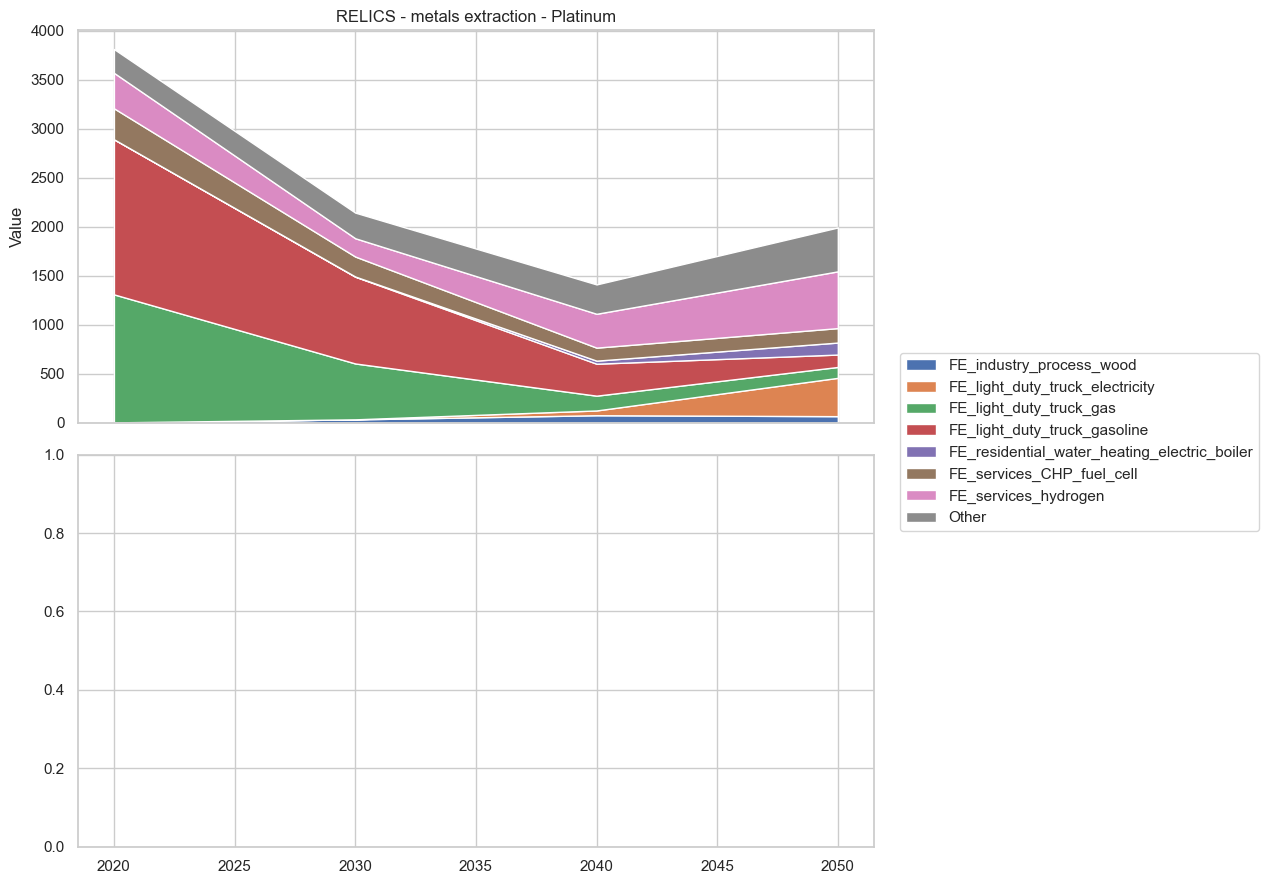

In [24]:
df_filtered = df_SPS1_Budg1150[
    (df_SPS1_Budg1150['quantile'] == 0.50) &
    (df_SPS1_Budg1150['impact_category'].isin(['RELICS - metals extraction - Platinum']))
]

# Separate data for Platinum and Palladium
df_platinum = df_filtered[df_filtered['impact_category'] == 'RELICS - metals extraction - Platinum']
df_palladium = df_filtered[df_filtered['impact_category'] == 'RELICS - metals extraction - Palladium']
df_barium = df_filtered[df_filtered['impact_category'] == 'RELICS - metals extraction - Barium']
df_tungsten = df_filtered[df_filtered['impact_category'] == 'RELICS - metals extraction - Tungsten']
df_hafnium = df_filtered[df_filtered['impact_category'] == 'RELICS - metals extraction - Hafnium']
df_vanadium = df_filtered[df_filtered['impact_category'] == 'RELICS - metals extraction - Vanadium']
df_lithium = df_filtered[df_filtered['impact_category'] == 'RELICS - metals extraction - Lithium']
df_cobalt = df_filtered[df_filtered['impact_category'] == 'RELICS - metals extraction - Cobalt']
df_gallium = df_filtered[df_filtered['impact_category'] == 'RELICS - metals extraction - Gallium']

def prepare_data(df):
    # Aggregate data by year and variable
    data = df.groupby(['year', 'variable'])['value'].sum().unstack().fillna(0)
    total = data.sum(axis=1)
    
    # Identify variables contributing less than 5%
    contribution = data.div(total, axis=0)
    others = contribution.columns[contribution.max() < 0.05]
    main = contribution.columns[contribution.max() >= 0.05]
    
    data['Other'] = data[others].sum(axis=1)
    data = data[main.tolist() + ['Other']]
    
    years = data.index
    values = data.values.T  # Transpose for stackplot
    labels = data.columns
    return years, values, labels

# Prepare data for Platinum
years_platinum, values_platinum, labels_platinum = prepare_data(df_platinum)

# Prepare data for Palladium
years_palladium, values_palladium, labels_palladium = prepare_data(df_palladium)

years_barium, values_barium, labels_barium = prepare_data(df_barium)
years_tungsten, values_tungsten, labels_tungsten = prepare_data(df_tungsten)
years_hafnium, values_hafnium, labels_hafnium = prepare_data(df_hafnium)
years_vanadium, values_vanadium, labels_vanadium = prepare_data(df_vanadium)
years_lithium, values_lithium, labels_lithium = prepare_data(df_lithium)
years_cobalt, values_cobalt, labels_cobalt = prepare_data(df_cobalt)
years_gallium, values_gallium, labels_gallium = prepare_data(df_gallium)



# Plotting the stacked area charts
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(9, 9), sharex=True)

# Plot for Platinum
axes[0].stackplot(years_platinum, values_platinum, labels=labels_platinum)
axes[0].set_title('RELICS - metals extraction - Platinum')
axes[0].set_ylabel('Value')



plt.tight_layout()
plt.show()

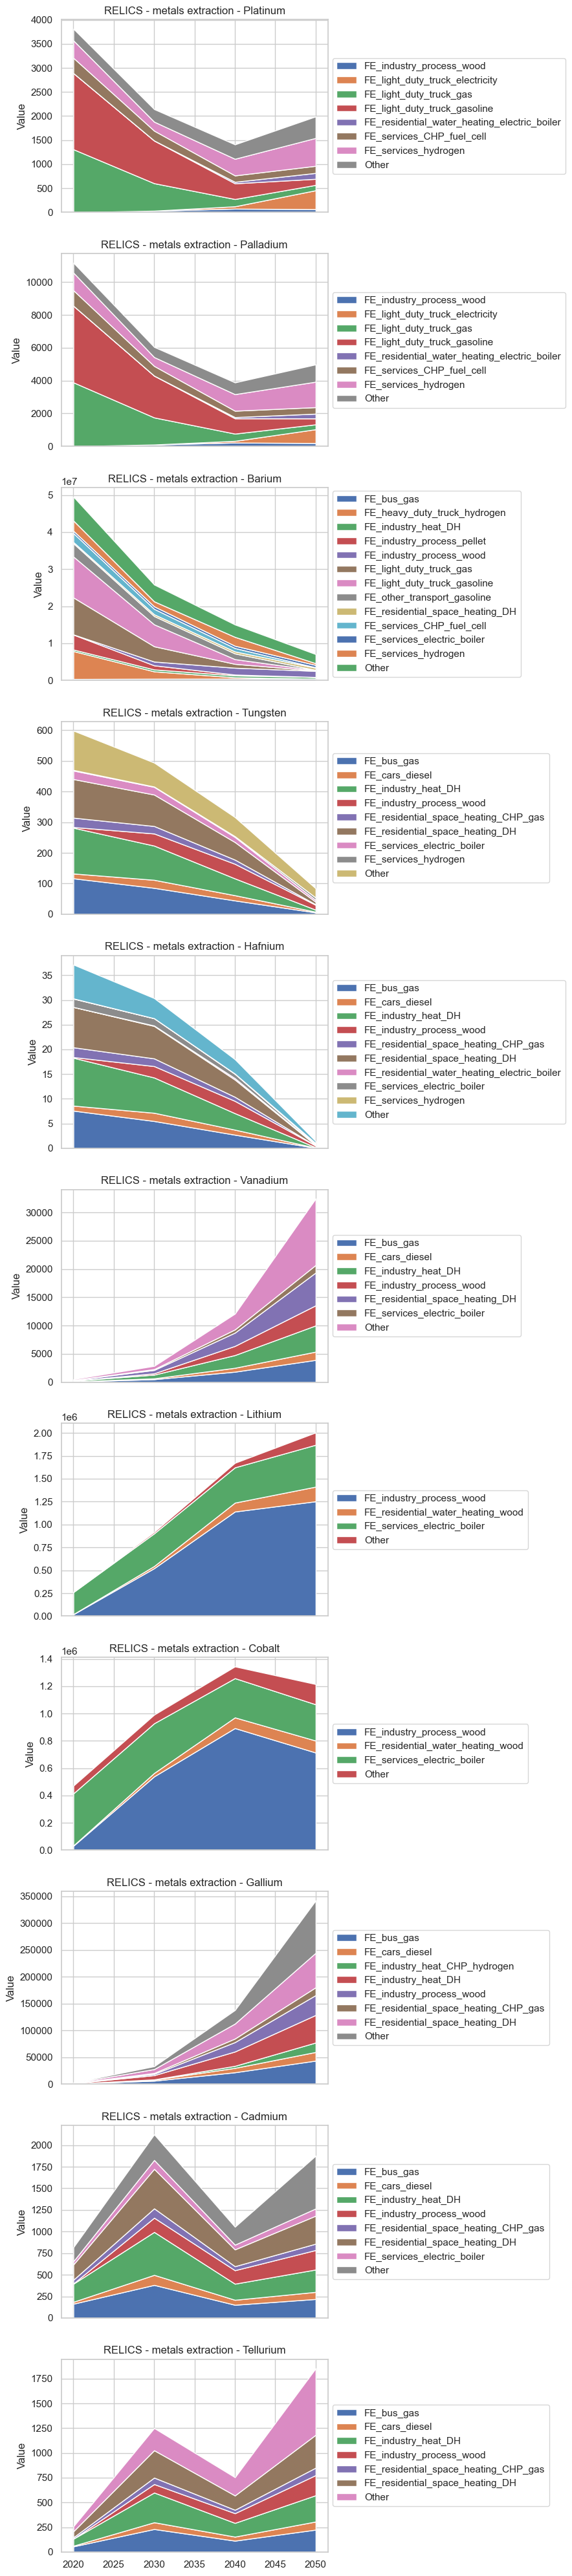

In [32]:

# Filter the data once
df_filtered = df_SPS1_Budg1150[
    (df_SPS1_Budg1150['quantile'] == 0.50) &
    (df_SPS1_Budg1150['impact_category'].isin([
        'RELICS - metals extraction - Platinum',
        'RELICS - metals extraction - Palladium',
        'RELICS - metals extraction - Barium',
        'RELICS - metals extraction - Tungsten',
        'RELICS - metals extraction - Hafnium',
        'RELICS - metals extraction - Vanadium',
        'RELICS - metals extraction - Lithium',
        'RELICS - metals extraction - Cobalt',
        'RELICS - metals extraction - Gallium',
        'RELICS - metals extraction - Cadmium',
        'RELICS - metals extraction - Tellurium',
    ]))
]

def prepare_data(df):
    # Aggregate data by year and variable
    data = df.groupby(['year', 'variable'])['value'].sum().unstack().fillna(0)
    total = data.sum(axis=1)
    
    # Identify variables contributing less than 5%
    contribution = data.div(total, axis=0)
    others = contribution.columns[contribution.max() < 0.05]
    main = contribution.columns[contribution.max() >= 0.05]
    
    data['Other'] = data[others].sum(axis=1)
    data = data[main.tolist() + ['Other']]
    
    years = data.index
    values = data.values.T  # Transpose for stackplot
    labels = data.columns
    return years, values, labels

# Define the impact categories to process
impact_categories = [
    'RELICS - metals extraction - Platinum',
    'RELICS - metals extraction - Palladium',
    'RELICS - metals extraction - Barium',
    'RELICS - metals extraction - Tungsten',
    'RELICS - metals extraction - Hafnium',
    'RELICS - metals extraction - Vanadium',
    'RELICS - metals extraction - Lithium',
    'RELICS - metals extraction - Cobalt',
    'RELICS - metals extraction - Gallium',
    'RELICS - metals extraction - Cadmium',
    'RELICS - metals extraction - Tellurium',
]

# Plotting the stacked area charts
fig, axes = plt.subplots(nrows=len(impact_categories), ncols=1, figsize=(9, 40), sharex=True)

for i, category in enumerate(impact_categories):
    # Filter the data for each impact category
    df_category = df_filtered[df_filtered['impact_category'] == category]
    
    # Prepare the data
    years, values, labels = prepare_data(df_category)
    
    # Plot the stacked area chart
    axes[i].stackplot(years, values, labels=labels)
    axes[i].set_title(category)
    axes[i].set_ylabel('Value')
    
    # Place the legend to the right of the plot
    axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to make room for legends
plt.tight_layout()
plt.show()

# SCENARIO FIGURES

I want to highlight the scenarios with a high share of SIB

In [10]:
impact_categories = {
    'Crustal Scarcity Indicator 2020 - material resources: metals/minerals - crustal scarcity potential (CSP)': 'Crustal Scarcity Indicator',
    'ReCiPe 2016 v1.03, midpoint (H) - particulate matter formation - particulate matter formation potential (PMFP)': 'Particulate matter formation',
    'RELICS - metals extraction - Copper': 'Copper',
    'RELICS - metals extraction - Lithium': 'Lithium',
    # 'RELICS - metals extraction - Cadmium': 'Cadmium',
    
}

In [11]:
dfs_total_impacts = []
dfs_tech_shares = []
dfs_monte_carlo = []
for file_path, year in zip(file_paths, years):
    df_total_impacts = pd.read_excel(file_path, sheet_name='Total impacts')
    df_total_impacts['year'] = year
    dfs_total_impacts.append(df_total_impacts)
    
    df_tech_shares = pd.read_excel(file_path, sheet_name='Technology shares')
    df_tech_shares['year'] = year
    dfs_tech_shares.append(df_tech_shares)

    df_monte_carlo = pd.read_excel(file_path, sheet_name='Monte Carlo values')
    df_monte_carlo['year'] = year
    dfs_monte_carlo.append(df_monte_carlo)

In [37]:
# Concatenate all dataframes
data_total_impacts = pd.concat(dfs_total_impacts)
data_tech_shares = pd.concat(dfs_tech_shares)
data_monte_carlo = pd.concat(dfs_monte_carlo)
# data_monte_carlo.fillna(0, inplace=True)
data_monte_carlo

,iteration,region,29550::328,18947::328,30853::328,32152::328,29550::491,29686::491,26985::491,31492::491,...,26998::29113,31505::29113,29563::29174,29699::29174,26998::29174,31505::29174,29563::29326,29699::29326,26998::29326,31505::29326
0,1,CH,1.612172,0.028306,0.001273,0.004436,1347.138075,2.335657,2314.407196,2.573659,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,CH,2.622804,0.017968,0.000950,0.003988,1211.804190,1.759654,2064.331510,3.899657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,CH,1.453078,0.034517,0.001384,0.004582,1285.052165,2.071367,2904.096785,3.114375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,CH,1.821208,0.023276,0.001419,0.007074,1117.430115,2.267329,2648.091247,2.270668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,CH,0.850590,0.034294,0.001204,0.005666,1359.343352,1.532022,3119.159761,2.225208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,CH,NaN,0.008008,NaN,NaN,NaN,NaN,NaN,NaN,...,2041.560388,9.850484,626.602164,17.031820,2385.810851,7.971038,3626.883959,102.601202,16639.740110,38.215494
96,97,CH,NaN,0.004322,NaN,NaN,NaN,NaN,NaN,NaN,...,2381.283067,11.297453,832.158814,17.502872,3573.605386,6.490831,2617.577035,96.245165,9988.263668,54.767012
97,98,CH,NaN,0.006326,NaN,NaN,NaN,NaN,NaN,NaN,...,3291.220530,8.994668,647.761036,17.009625,1863.000957,9.208113,4257.771001,93.084747,13487.708940,52.794883
98,99,CH,NaN,0.007355,NaN,NaN,NaN,NaN,NaN,NaN,...,3899.642341,9.516549,735.159773,18.526891,1444.056040,8.937173,3174.563279,101.942314,14454.939717,48.120020


In [38]:
numeric_cols_total_impacts = data_total_impacts.select_dtypes(include=['number']).columns
data_total_impacts_numeric = data_total_impacts[numeric_cols_total_impacts]

numeric_cols_tech_shares = data_tech_shares.select_dtypes(include=['number']).columns
data_tech_shares_numeric = data_tech_shares[numeric_cols_tech_shares]

numeric_cols_monte_carlo = data_monte_carlo.select_dtypes(include=['number']).columns
data_monte_carlo_numeric = data_monte_carlo[numeric_cols_monte_carlo]

In [39]:
quantiles_total_impacts = data_total_impacts_numeric.groupby('year').quantile([0.05, 0.5, 0.95]).unstack(level=1)

In [44]:
conditions = [
    # {
    #     'name': 'SIB and Monte Carlo',
    #     'data': [data_tech_shares_numeric, data_monte_carlo_numeric],
    #     'columns': [['Battery-Stationary - SIB-Stationary', 'Battery-Mobile - SIB'], ['32163::328']],
    #     'thresholds': [0.75, 0.75],
    #     'color': 'blue',
    #     'alpha': 1
    # },
    {
        'name': 'SIB',
        'data': [data_tech_shares_numeric],
        'columns': [['Battery-Stationary - SIB-Stationary', 'Battery-Mobile - SIB']],
        'thresholds': [0.75],
        'color': 'blue',
        'alpha': 1
    },
    {
        'name': 'PV - CdTe',
        'data': [data_tech_shares_numeric],
        'columns': [['PV - CdTe']],
        'thresholds': [0.95],
        'color': 'red',
        'alpha': 0.5
    }
]

In [45]:
# # Initialize a dictionary to store the iterations for each condition by year
# iterations_dict = {year: {} for year in years}

# # Calculate and store the iterations for each condition by year
# for condition in conditions:
#     print(f"Condition: {condition['name']}")
#     for year in years:
#         year_masks = []
#         for data, cols, threshold in zip(condition['data'], condition['columns'], condition['thresholds']):
#             year_data = data[data['year'] == year]
#             for col in cols:
#                 if year_data[col].isna().all():
#                     # print(f"Year: {year}, Column: {col} contains only NaN values.")
#                     continue
#                 quantiles = year_data.groupby('year')[col].quantile(threshold)
#                 # print(f"Year: {year}, Column: {col}, Quantiles: {quantiles}")
#                 year_mask = year_data[col] > quantiles.iloc[0]
#                 year_masks.append(year_mask)
#         if year_masks:  # Ensure there are masks to concatenate
#             combined_year_mask = pd.concat(year_masks, axis=1).all(axis=1)
#             valid_indices = year_data.index[combined_year_mask]  # Get valid indices
#             iterations_dict[year][condition['name']] = data_tech_shares.loc[valid_indices, 'iteration'].unique()
#         else:
#             iterations_dict[year][condition['name']] = []
#         print(f"Year: {year}, Iterations: {iterations_dict[year][condition['name']]}")

In [46]:
iterations_dict = {}

# Calculate and store the iterations for each condition
for condition in conditions:
    masks = []
    for data, cols, threshold in zip(condition['data'], condition['columns'], condition['thresholds']):
        for col in cols:
            quantiles = data.groupby('year')[col].quantile(threshold)
            broadcasted_quantiles = data.set_index('year').index.map(quantiles.to_dict())
            masks.append(data[col] > broadcasted_quantiles)
    combined_mask = pd.concat(masks, axis=1).all(axis=1)
    iterations_dict[condition['name']] = data_tech_shares[combined_mask]['iteration'].unique()

iterations_dict

{'SIB and Monte Carlo': array([16, 42, 54, 82, 90], dtype=int64),
 'PV - CdTe': array([ 17,  61,  62,  85, 100], dtype=int64)}

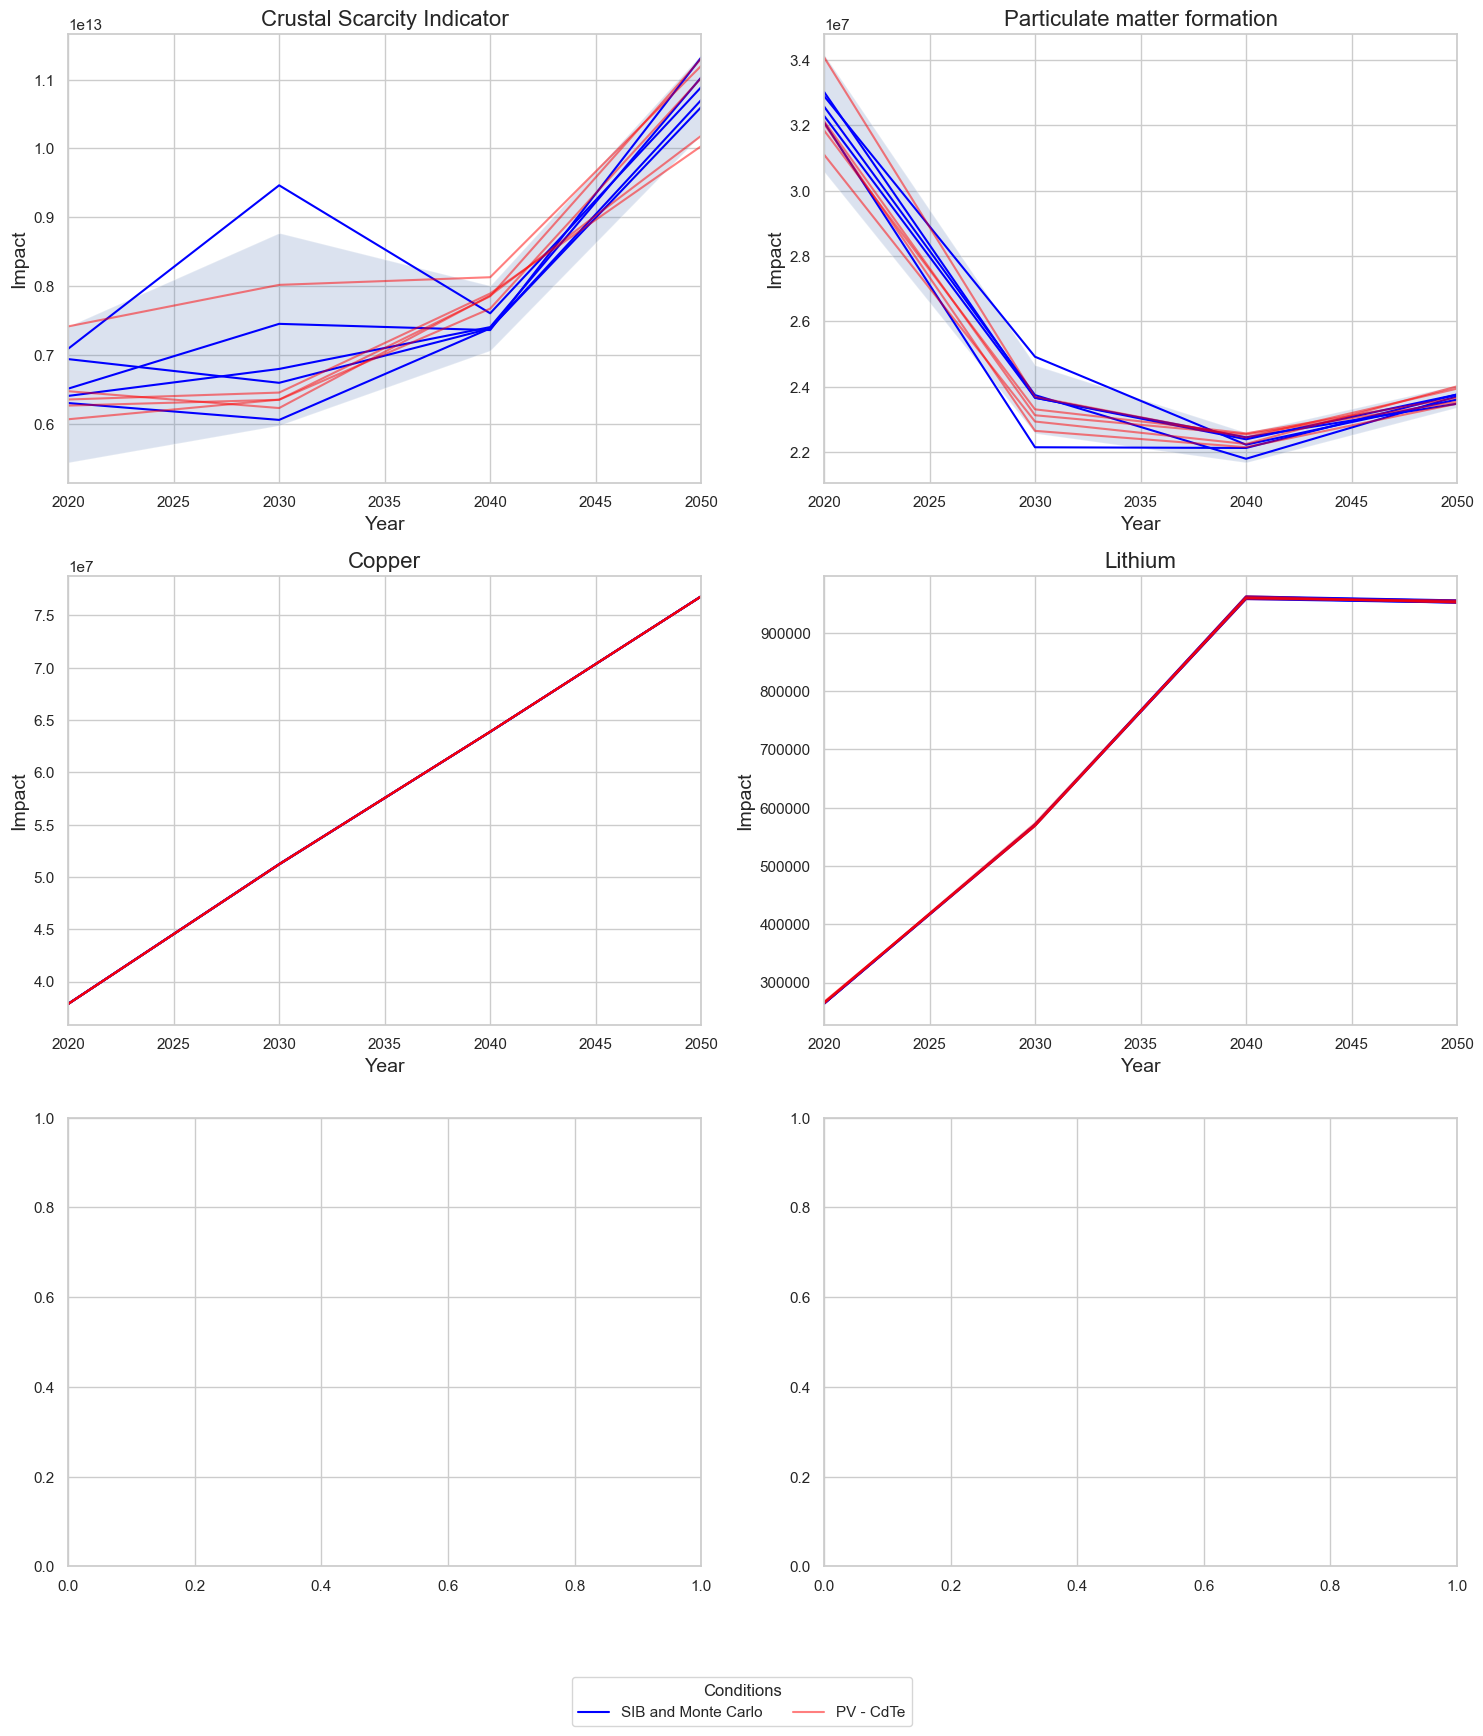

In [47]:
# Plot for each impact category using Seaborn
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
axes = axes.flatten()

all_handles = []
all_labels = []
plotted_labels = set()  # Move this outside the loop to keep track globally

for ax, (category, display_name) in zip(axes, impact_categories.items()):
    sns.set(style="whitegrid")

    # Plot quantile ranges without the 0.5 quantile line
    q05 = quantiles_total_impacts[(category, 0.05)]
    q95 = quantiles_total_impacts[(category, 0.95)]
    ax.fill_between(years, q05, q95, alpha=0.2)

    # Plot lines for each condition
    for condition in conditions:
        condition_label_added = False
        for iteration in iterations_dict[condition['name']]:
            iter_data = data_total_impacts[data_total_impacts['iteration'] == iteration]
            y_values = iter_data.set_index('year')[category].reindex(years, method='ffill')
            label = condition['name'] if condition['name'] not in plotted_labels else "_nolegend_"
            lineplot = sns.lineplot(x=years, y=y_values, ax=ax, color=condition['color'], label=label, alpha=condition.get('alpha', 1.0))
            if condition['name'] not in plotted_labels:  # Collect handles and labels only if the label is not already plotted
                handle = plt.Line2D([], [], color=condition['color'], label=condition['name'], alpha=condition.get('alpha', 1.0))
                all_handles.append(handle)
                all_labels.append(condition['name'])
                plotted_labels.add(condition['name'])

    ax.set_title(display_name, fontsize=16)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Impact', fontsize=14)
    ax.set_xlim(2020, 2050)
    ax.grid(True)
    legend = ax.get_legend()
    if legend:
        legend.remove()  # Correctly remove the legend for this subplot

# Add a single legend centered under the two bottom plots
fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=3, title='Conditions')
plt.tight_layout(rect=[0, 0.1, 1, 1])
# plt.savefig('impact_categories_combined_with_conditions.png', dpi=300)
plt.show()
